# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's exitsting architecture and learned patterns for over own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [2]:
# Are we using a GPU?
!nvidia-smi

Mon Oct 31 05:17:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading and becoming one with the data

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-10-31 05:17:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   297MB/s    in 0.5s    

2022-10-31 05:17:49 (297 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images in each folder?
import os
# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

Notice: how each of the training directories now has 75 images rather than 750 images.  
This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images.  
This means we'll be training on less data but evaluating our models on the same amount of test data.

## Creating data loaders (preparing the data)

Now we've downloaded the data, we'll the ImageDataGenerator class along with the flow_from_directory method to load in our images.

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image shape and batch size
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Set train and test data set
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Set train and test datagen
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
Some of the most popular callbacks:
* **Tracking experiments with the TensorBoard callback** : log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* **Model checkpoint with the ModelCheclpoint callback** : save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* **Stopping a model from training (before it trains too long and overfits)with the EarlyStoping callback** : leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [1]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub
In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.
We can access pretrained models on: https://tfhub.dev/

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in output layer,
        should be equal to number of target classes, default 10.

    Returns:
      An uncompiled Keras Sequential model with model_url as feature
      extractor layer and Dense output layer with num_classes outputs.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # freeze the underlying patterns
                                            name='feature_extraction_layer',
                                            input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
    
    # Create our own model
    model = tf.keras.Sequential([
      feature_extractor_layer, # use the feature extraction layer as the base
      layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
    ])

    return model

### Creating and testing ResNet Tensoflow Hub Feature Extraction model

In [9]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)


In [10]:
# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221031-051902
Epoch 1/5
24/24 [==============================] - 30s 778ms/step - loss: 1.9443 - accuracy: 0.3480 - val_loss: 1.2819 - val_accuracy: 0.5996
Epoch 2/5
24/24 [==============================] - 16s 680ms/step - loss: 0.9461 - accuracy: 0.7093 - val_loss: 0.8871 - val_accuracy: 0.7152
Epoch 3/5
24/24 [==============================] - 17s 717ms/step - loss: 0.6327 - accuracy: 0.8147 - val_loss: 0.7644 - val_accuracy: 0.7488
Epoch 4/5
24/24 [==============================] - 17s 719ms/step - loss: 0.4941 - accuracy: 0.8747 - val_loss: 0.7210 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 16s 677ms/step - loss: 0.3999 - accuracy: 0.9067 - val_loss: 0.6895 - val_accuracy: 0.7844


Wow!

It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 10 percent of the training images!

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our plot_loss_curves function.

In [13]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args: 
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

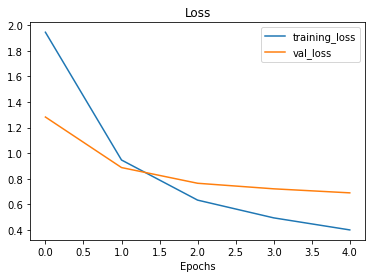

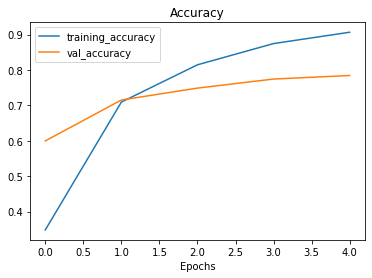

In [14]:
plot_loss_curves(resnet_history)

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Our transfer learning feature extractor model out performed ALL of the previous models we built by hand ... (substantially) and in a quicker training time and with only 10% of the training examples

### Creating and testing EfficientNetB0 Tensoflow Hub Feature Extraction model

In [17]:
#Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)
#Compile EfficientNet Model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])
#Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20221031-054531
Epoch 1/5
24/24 [==============================] - 26s 731ms/step - loss: 1.8460 - accuracy: 0.4307 - val_loss: 1.3020 - val_accuracy: 0.7280
Epoch 2/5
24/24 [==============================] - 15s 654ms/step - loss: 1.0616 - accuracy: 0.7880 - val_loss: 0.8697 - val_accuracy: 0.8088
Epoch 3/5
24/24 [==============================] - 15s 657ms/step - loss: 0.7521 - accuracy: 0.8333 - val_loss: 0.6988 - val_accuracy: 0.8360
Epoch 4/5
24/24 [==============================] - 15s 661ms/step - loss: 0.6050 - accuracy: 0.8680 - val_loss: 0.6097 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 15s 658ms/step - loss: 0.5124 - accuracy: 0.8907 - val_loss: 0.5604 - val_accuracy: 0.8572


The EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 85% accuracy on the test set...again with only 10% of the training data.

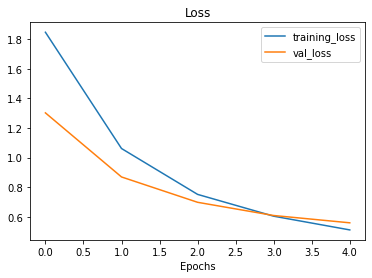

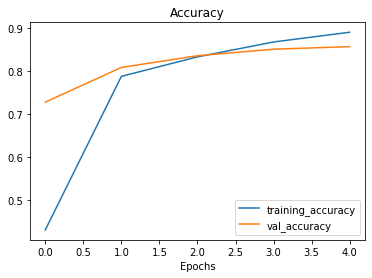

In [18]:
plot_loss_curves(efficientnet_history)

From the look of the EfficientNetB0 model's loss curves, it looks like if we kept training our model for longer, it might improve even further. Perhaps that's something you might want to try?

Let's check out the model summary.

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of Transfer Learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (eg using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (eg. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing result models using TensorBoard

>🔑 Note: TensorBoard.dev experiments are public, do not upload sensitive data. You can delete experiments if needed.

Where:

* --logdir is the target upload directory
* --name is the name of the experiment
* --description is a brief description of the experiment
* --one_shot exits the TensorBoard uploader once uploading is finished
Running the tensorboard dev upload command will first ask you to authorize the upload to TensorBoard.dev. After you've authorized the upload, your log files will be uploaded.

In [25]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=uCFnilxUyL3mhDAr2UdfIqQPTTqHC7&prompt=consent&access_type=off

Our Tensoboard experiments are uploaded publically here: https://tensorboard.dev/experiment/wNjj0fahQiWDk32wuExdHQ/

### Listing experiments you've saved to TensorBoard
To see all of the experiments you've uploaded you can use the command:

tensorboard dev list

In [26]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/wNjj0fahQiWDk32wuExdHQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training data
	Id                   wNjj0fahQiWDk32wuExdHQ
	Created              2022-10-31 06:29:43 (8 minutes ago)
	Updated              2022-10-31 06:29:48 (8 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
Total: 1 experiment(s)


### Deleting experiments from TensorBoard
Remember, all uploads to TensorBoard.dev are public, so to delete an experiment you can use the command:

tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]

In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id ???????????????????????

In [ ]:
# Check to see if experiments still exist
!tensorboard dev list

## 🛠 Exercises

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([`mobilenet_v2_100_224/feature_vector`](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) from TensorFlow Hub, how does it perform compared to our other models?
2. Name 3 different image classification models on TensorFlow Hub that we haven't used.
3. Build a model to classify images of two different things you've taken photos of.
  * You can use any feature extraction layer from TensorFlow Hub you like for this.
  * You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.
4. What is the current best performing model on ImageNet?
  * Hint: you might want to check [sotabench.com](https://www.sotabench.com) for this.

In [28]:
# MobileNetV2
mobilenetv2_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [29]:
#Create MobileNetV2 feature extractor model
mobilenetv2_model = create_model(model_url=mobilenetv2_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)
#Compile MobileNetV2 Model
mobilenetv2_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])
#Fit MobileNetV2 model to 10% of training data
mobilenetv2_history = mobilenetv2_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="mobilenetv2")])

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20221031-065142
Epoch 1/5
24/24 [==============================] - 20s 677ms/step - loss: 1.9215 - accuracy: 0.3747 - val_loss: 1.2862 - val_accuracy: 0.6040
Epoch 2/5
24/24 [==============================] - 16s 696ms/step - loss: 1.0717 - accuracy: 0.6733 - val_loss: 0.9390 - val_accuracy: 0.7156
Epoch 3/5
24/24 [==============================] - 16s 674ms/step - loss: 0.7547 - accuracy: 0.7893 - val_loss: 0.7561 - val_accuracy: 0.7712
Epoch 4/5
24/24 [==============================] - 15s 660ms/step - loss: 0.5955 - accuracy: 0.8360 - val_loss: 0.6989 - val_accuracy: 0.7780
Epoch 5/5
24/24 [==============================] - 16s 674ms/step - loss: 0.4936 - accuracy: 0.8733 - val_loss: 0.6559 - val_accuracy: 0.7888


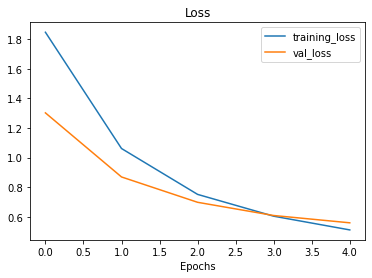

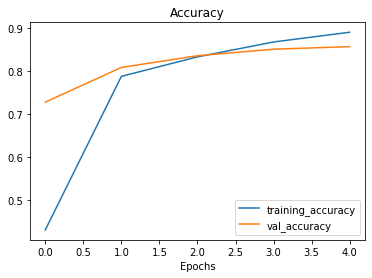

In [30]:
plot_loss_curves(efficientnet_history)

In [31]:
mobilenetv2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Mobile Net V2" \
  --description "Mobile Net V2: architectures using 10% of training data" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/UDZxAY5ERa6OckRfGVz3Ag/

[2022-10-31T06:54:52] Started scanning logdir.
[2022-10-31T06:54:57] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (7.2 MB)
[2022-10-31T06:54:57] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/UDZxAY5ERa6OckRfGVz3Ag/
